# CNN Model using full Ford data now

In [225]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Normalization
%matplotlib inline
import seaborn as sns
from keras.models import Sequential 
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, InputLayer
from keras.utils.np_utils import to_categorical

from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import TimeSeriesSplit

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression


## Part 1: Clean and Select Data

In [226]:
pd.set_option('display.max_columns', None)

In [227]:
Ford = pd.read_csv("Ford_Cleaned_Date.csv")
Ford.date = pd.to_datetime(Ford.date)
Ford = Ford.set_index("date")
Ford = Ford.iloc[14:, :] # to remove first 14 days that include NaNs due to some calculations
Ford = Ford.drop(["Nas_total", 'Stock_total', 'Dow_total'],axis=1) # to remove duplicated columns
pd.DataFrame(Ford.isna().sum()).T

,Ford,F-150,Ford Bronco_x,Ford Mustang_x,Ford Stock,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ford Motor Company,Ford Mustang_y,Ford F Series,Ford Bronco_y,Lincoln Navigator,Lincoln Aviator,Ford GT,dow_open,dow_high,dow_low,dow_close,dow_vol,nas_open,nas_high,nas_low,nas_close,nas_vol,Wiki_total,Google_total,Stock_total,Nas_total,Dow_total,Wiki_Moment_1,Wiki_Moment_2,Wiki_Moment_1_s,Wiki_Moment_2_s,Wiki_MAvg,Wiki_MAvg_s,Wiki_Disparity,Wiki_Disparity_s,Wiki_ROC,Wiki_ROC_s,Wiki_Rocp,Wiki_EMA,Wiki_diff,Wiki_gain,Wiki_loss,Wiki_avg_gain,Wiki_avg_loss,Wiki_rs,Wiki_RSI,Wiki_Move,Wiki_MAvg_Move,Wiki_MAvg_s_Move,Wiki_EMA_Move,Wiki_Disparity_Move,Wiki_Disparity_s_Move,Wiki_RSI_Move,Google_Moment_1,Google_Moment_2,Google_Moment_1_s,Google_Moment_2_s,Google_MAvg,Google_MAvg_s,Google_Disparity,Google_Disparity_s,Google_ROC,Google_ROC_s,Google_Rocp,Google_EMA,Google_diff,Google_gain,Google_loss,Google_avg_gain,Google_avg_loss,Google_rs,Google_RSI,Google_Move,Google_MAvg_Move,Google_MAvg_s_Move,Google_EMA_Move,Google_Disparity_Move,Google_Disparity_s_Move,Google_RSI_Move,Stock_Moment_1,Stock_Moment_2,Stock_Moment_1_s,Stock_Moment_2_s,Stock_MAvg,Stock_MAvg_s,Stock_Disparity,Stock_Disparity_s,Stock_ROC,Stock_ROC_s,Stock_Rocp,Stock_EMA,Stock_diff,Stock_gain,Stock_loss,Stock_avg_gain,Stock_avg_loss,Stock_rs,Stock_RSI,Stock_Move,Stock_MAvg_Move,Stock_MAvg_s_Move,Stock_EMA_Move,Stock_Disparity_Move,Stock_Disparity_s_Move,Stock_RSI_Move,Nas_Moment_1,Nas_Moment_2,Nas_Moment_1_s,Nas_Moment_2_s,Nas_MAvg,Nas_MAvg_s,Nas_Disparity,Nas_Disparity_s,Nas_ROC,Nas_ROC_s,Nas_Rocp,Nas_EMA,Nas_diff,Nas_gain,Nas_loss,Nas_avg_gain,Nas_avg_loss,Nas_rs,Nas_RSI,Nas_Move,Nas_MAvg_Move,Nas_MAvg_s_Move,Nas_EMA_Move,Nas_Disparity_Move,Nas_Disparity_s_Move,Nas_RSI_Move,Dow_Moment_1,Dow_Moment_2,Dow_Moment_1_s,Dow_Moment_2_s,Dow_MAvg,Dow_MAvg_s,Dow_Disparity,Dow_Disparity_s,Dow_ROC,Dow_ROC_s,Dow_Rocp,Dow_EMA,Dow_diff,Dow_gain,Dow_loss,Dow_avg_gain,Dow_avg_loss,Dow_rs,Dow_RSI,Dow_Move,Dow_MAvg_Move,Dow_MAvg_s_Move,Dow_EMA_Move,Dow_Disparity_Move,Dow_Disparity_s_Move,Dow_RSI_Move,target_1,target_2,target_3,target_4,target_5
0,0,0,0,0,0,6,6,6,6,6,6,6,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,0,0,6,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,11,11,11,0,0,6,6,11,11,11,6,11,11,11,76,76,76,76,0,0,0,0,0,0,0,7,7,7,7,0,0,4,4,7,7,7,4,7,7,7,46,46,46,46,0,0,0,0,0,0,0,7,7,7,7,0,0,4,4,7,7,7,4,7,7,7,46,46,46,46,0,0,0,0,0,0,0,0,0,0,0,0


We see from above that some varaibles contain a lot of NaN's so they either might not be useful, or they're going to lead us into eliminating a lot of data points.

To Solve NaN problem we will create two initial data sets, one removing high NaN values, one not, and see which produced better results.

In [228]:
#Ford = Ford.drop([['Ford', 'Ford_Bronco_x', 'Ford_Stock', 'F-150', 'Ford_Bronco_y', 'Ford Motor Company', 'Ford F Series', 'Lincoln Navigator', 'Lincoln Aviator']], axis=1)

In [229]:
# High NaN varaibles included will be Ford_0
Ford_0 = Ford.dropna()
Ford_0 = Ford_0[~(Ford_0.isin([np.inf, -np.inf]).any(axis=1))] # to remove inf

# Ford_1 will remove the high NaN columns
Ford_1 = Ford[Ford.columns.drop(list(Ford.filter(regex='gain')))]
Ford_1 = Ford_1[Ford_1.columns.drop(list(Ford_1.filter(regex='loss')))]
Ford_1 = Ford_1[Ford_1.columns.drop(list(Ford_1.filter(regex='RSI')))]
Ford_1 = Ford_1[Ford_1.columns.drop(list(Ford_1.filter(regex='_rs')))]
Ford_1 = Ford_1.dropna()
Ford_1 = Ford_1[~(Ford_1.isin([np.inf, -np.inf]).any(axis=1))]

Ford_0.shape,Ford_1.shape

((709, 169), (768, 134))

In [230]:
# Target Chosen is target_3
Ford_0 = Ford_0.drop(['target_1', 'target_2', 'target_4', 'target_5'], axis=1)
Ford_1 = Ford_1.drop(['target_1', 'target_2', 'target_4', 'target_5'], axis=1)

target_3_0 = Ford_0["target_3"]
target_3_1 = Ford_1["target_3"]

In [231]:
target_3_1.shape, Ford_1.shape

((768,), (768, 130))

In [232]:
#splitting into training sets 
column_indices = {name: i for i, name in enumerate(Ford_1.columns)}

n = len(Ford_0)
train_f0 = Ford_0[0:int(n*0.7)]
val_f0 = Ford_0[int(n*0.7):int(n*0.9)]
test_f0 = Ford_0[int(n*0.9):]

train_f0t = target_3_0[0:int(n*0.7)]
val_f0t = target_3_0[int(n*0.7):int(n*0.9)]
test_f0t = target_3_0[int(n*0.9):]

# now with Ford_1
n = len(Ford_1)
train_f1 = Ford_1[0:int(n*0.7)]
val_f1 = Ford_1[int(n*0.7):int(n*0.9)]
test_f1 = Ford_1[int(n*0.9):]

train_f1t = target_3_1[0:int(n*0.7)]
val_f1t = target_3_1[int(n*0.7):int(n*0.9)]
test_f1t = target_3_1[int(n*0.9):]

In [233]:
# preporocessing and standardizing the data
Mscaler = MinMaxScaler() # keeps binarys at zero and 1 :)

train_f0 = pd.DataFrame(Mscaler.fit_transform(train_f0), columns = Ford_0.columns)
val_f0 = pd.DataFrame(Mscaler.fit_transform(val_f0), columns = Ford_0.columns)
test_f0 = pd.DataFrame(Mscaler.fit_transform(test_f0), columns = Ford_0.columns)

train_f1 = pd.DataFrame(Mscaler.fit_transform(train_f1), columns = Ford_1.columns)
val_f1 = pd.DataFrame(Mscaler.fit_transform(val_f1), columns = Ford_1.columns)
test_f1 = pd.DataFrame(Mscaler.fit_transform(test_f1), columns = Ford_1.columns)

In [234]:
# Time series data modifier, will be used later

def df_to_X_y2(df, target, window_size=5):
  df_as_np = df.to_numpy() # converts to matrix of numpy arrays
  X = []
  y = []
  for i in range(len(df_as_np)-window_size): # length of data frame - window_size so it does't take empty values at the end, 
    # does force you to loose the last 5 values, could fix with padding
    row = [r for r in df_as_np[i:i+window_size]] # grabs row i and all rows above within the window size length
    X.append(row) # creates 3 dimentional array, (# obseravtions, # rows in window, # features)
    label = target[i+window_size] # pulls the target variable after the window, target varible needs to be column zero in this 
    y.append(label) # returns (N,) martix of targets i+window_length time periods away
  return np.array(X), np.array(y)

## Switching Focus to Just Ford_0, High NaN Varibles included

In [235]:
# apply SelectKBest class to extract top 40 best features
bestfeatures = SelectKBest(score_func=f_regression, k=40)
best_fit = bestfeatures.fit(train_f0, train_f0t)
best_scores = pd.DataFrame(best_fit.scores_)
best_columns = pd.DataFrame(Ford_0.columns)

# concatenate the dataframes for better visualization
features_score = pd.concat([best_columns, best_scores], axis=1)
features_score.columns = ['Features', 'Score']  # naming the dataframe columns
print(features_score.nlargest(40, 'Score'))  # print the top 10 best features

                   Features         Score
164                target_3  1.853982e+17
57      Wiki_Disparity_Move  5.048879e+00
155                  Dow_rs  3.490399e+00
58    Wiki_Disparity_s_Move  3.014178e+00
3            Ford Mustang_x  2.128389e+00
53                Wiki_Move  2.075053e+00
52                 Wiki_RSI  2.059093e+00
154            Dow_avg_loss  2.040229e+00
75          Google_avg_gain  1.990507e+00
41         Wiki_Disparity_s  1.941543e+00
128            Nas_avg_loss  1.866438e+00
87           Stock_Moment_2  1.839803e+00
110  Stock_Disparity_s_Move  1.623449e+00
4                Ford Stock  1.510923e+00
136    Nas_Disparity_s_Move  1.426169e+00
148                Dow_Rocp  1.350381e+00
82          Google_EMA_Move  1.347818e+00
153            Dow_avg_gain  1.339265e+00
76          Google_avg_loss  1.188484e+00
10                Dividends  1.159343e+00
15            Ford Bronco_y  1.009442e+00
70              Google_Rocp  9.298293e-01
104               Stock_RSI  9.298

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


In [236]:
feats = list(features_score.nlargest(40, 'Score')['Features'])

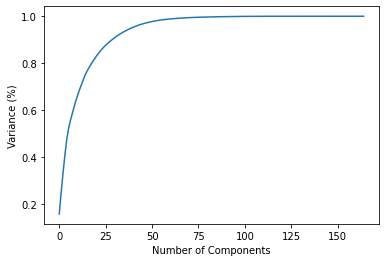

array([ 15.68433691,  24.74667373,  33.10378249,  40.54965109,
        47.39486325,  52.10029515,  55.50687153,  58.50470073,
        61.42530001,  64.16698358,  66.53422149,  68.88994394,
        71.02367211,  73.08023374,  75.02227321,  76.60158477,
        78.0620214 ,  79.39525157,  80.67360492,  81.84725939,
        83.00384916,  84.08061599,  85.07367374,  86.01668656,
        86.88167021,  87.66126402,  88.38898007,  89.07250363,
        89.72934819,  90.35721032,  90.96092432,  91.51678808,
        92.05310805,  92.55542469,  93.03539412,  93.48671903,
        93.90272285,  94.30439446,  94.68386345,  95.03240113,
        95.3773965 ,  95.69977774,  96.00449478,  96.27854221,
        96.53127052,  96.77177334,  96.99681187,  97.20554906,
        97.39294777,  97.57709392,  97.74530298,  97.90443261,
        98.05346752,  98.18960852,  98.31107071,  98.42348617,
        98.52366819,  98.62112629,  98.70982943,  98.7923154 ,
        98.86712008,  98.9372757 ,  99.00342101,  99.06

In [237]:
# PCA 
pca = PCA().fit(train_f0)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') # for each component
plt.show()
np.cumsum(pca.explained_variance_ratio_) * 100
# reach 85% variance explained with 23 principle components

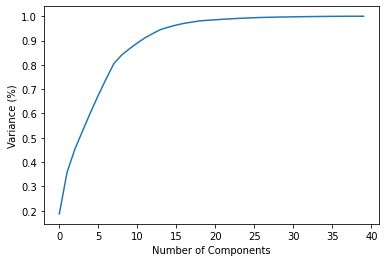

array([ 18.66241111,  35.84253923,  45.30504038,  52.922487  ,
        60.4248241 ,  67.50426855,  74.21093435,  80.54626761,
        84.05727658,  86.62596149,  88.99254744,  91.1645831 ,
        92.92216156,  94.55803141,  95.52117579,  96.38660887,
        97.08481547,  97.60281808,  98.08808651,  98.32139431,
        98.54934806,  98.75599665,  98.94597887,  99.12335478,
        99.26581491,  99.39748682,  99.50860948,  99.5814469 ,
        99.64646238,  99.70346206,  99.75636888,  99.8053512 ,
        99.85332717,  99.89527546,  99.92696851,  99.95199898,
        99.97634481,  99.99802256, 100.        , 100.        ])

In [238]:
#PCA with 40 best components
pca_1 = PCA().fit(train_f0[feats])
plt.figure()
plt.plot(np.cumsum(pca_1.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') # for each component
plt.show()
np.cumsum(pca_1.explained_variance_ratio_) * 100
# can use 8 principle compents now

Keeping score: Will test 5 models with Ford_0 data variations,
- Model_0_0 = All varaibles,
- Model_0_1 = PCA All varaibles
- Model_0_2 = 40 best k score
- Model_0_3 = PCA of 40 Best K Score

### Model_0_0

In [239]:
# Model_0_0 final data prep

# converting to window format, in this case 5 periods
train_X_0_0, train_f0t_tc = df_to_X_y2(train_f0,train_f0t)
val_X_0_0, val_f0t_tc= df_to_X_y2(val_f0, val_f0t)
test_X_0_0, test_f0t_tc = df_to_X_y2(test_f0,test_f0t) 

In [240]:
len(train_f0t), len(train_X_0_0)

(496, 491)

In [241]:
train_X_0_0.shape[2]

165

In [242]:
n_steps = train_X_0_0.shape[1]
n_features = train_X_0_0.shape[2]

model_0_0_1 = Sequential()
model_0_0_1.add(Conv1D(filters=5, kernel_size=2, activation='relu', input_shape=(n_steps,n_features))) 
model_0_0_1.add(MaxPooling1D(pool_size=2)) 
model_0_0_1.add(Flatten())
model_0_0_1.add(Dense(50, activation='relu')) 
model_0_0_1.add(Dense(1, activation='sigmoid'))

model_0_0_1.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_0_1.fit(train_X_0_0, train_f0t_tc,epochs=100,  validation_data=(val_X_0_0, val_f0t_tc))

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


16/16 [==============================] - 1s 16ms/step - loss: 0.6946 - accuracy: 0.5153 - val_loss: 0.6989 - val_accuracy: 0.4599
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.5316 - val_loss: 0.6978 - val_accuracy: 0.4599
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6905 - accuracy: 0.5173 - val_loss: 0.6924 - val_accuracy: 0.4964
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6899 - accuracy: 0.5214 - val_loss: 0.6921 - val_accuracy: 0.5328
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6884 - accuracy: 0.5377 - val_loss: 0.6949 - val_accuracy: 0.5255
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6879 - accuracy: 0.5193 - val_loss: 0.6891 - val_accuracy: 0.5547
Epoch 7/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6855 - accuracy: 0.5336 - val_loss: 0.6933 - val_accuracy: 0.5401
Epoch 8/100
16/16 [=====

In [243]:
model_0_0_2 = Sequential()
model_0_0_2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features))) 
model_0_0_2.add(MaxPooling1D(pool_size=2)) 
model_0_0_2.add(Flatten())
model_0_0_2.add(Dense(50, activation='relu')) 
model_0_0_2.add(Dense(1, activation='sigmoid'))

model_0_0_2.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_0_2.fit(train_X_0_0,train_f0t_tc,epochs=100,  validation_data=(val_X_0_0, val_f0t_tc))

Epoch 1/100
16/16 [==============================] - 1s 15ms/step - loss: 0.7052 - accuracy: 0.4949 - val_loss: 0.6997 - val_accuracy: 0.5182
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6860 - accuracy: 0.5438 - val_loss: 0.6880 - val_accuracy: 0.5036
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6743 - accuracy: 0.5743 - val_loss: 0.6986 - val_accuracy: 0.5182
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6659 - accuracy: 0.6191 - val_loss: 0.6875 - val_accuracy: 0.5401
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.6541 - accuracy: 0.6415 - val_loss: 0.7213 - val_accuracy: 0.5182
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6575 - accuracy: 0.6130 - val_loss: 0.6913 - val_accuracy: 0.5036
Epoch 7/100
16/16 [==============================] - 0s 6ms/step - loss: 0.6449 - accuracy: 0.6354 - val_loss: 0.7141 - val_accuracy: 0.4964
Epoch 8/100


In [244]:
model_0_0_3 = Sequential()
model_0_0_3.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_0_0_3.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_0_3.add(MaxPooling1D(pool_size=2)) 
model_0_0_3.add(Flatten())
model_0_0_3.add(Dense(50, activation='relu')) 
model_0_0_3.add(Dense(1, activation='sigmoid')) 

model_0_0_3.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_0_3.fit(train_X_0_0,train_f0t_tc,epochs=100,  validation_data=(val_X_0_0, val_f0t_tc))

Epoch 1/100
16/16 [==============================] - 1s 17ms/step - loss: 0.7076 - accuracy: 0.4827 - val_loss: 0.6956 - val_accuracy: 0.5109
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.6906 - accuracy: 0.5499 - val_loss: 0.6920 - val_accuracy: 0.4891
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6944 - accuracy: 0.5214 - val_loss: 0.6907 - val_accuracy: 0.5328
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6875 - accuracy: 0.5479 - val_loss: 0.6884 - val_accuracy: 0.5401
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6894 - accuracy: 0.5336 - val_loss: 0.6911 - val_accuracy: 0.5109
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6780 - accuracy: 0.5743 - val_loss: 0.6874 - val_accuracy: 0.5401
Epoch 7/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6679 - accuracy: 0.5927 - val_loss: 0.6846 - val_accuracy: 0.5401
Epoch 8/100


In [245]:
model_0_0_4 = Sequential()
model_0_0_4.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_0_0_4.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_0_4.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_0_4.add(MaxPooling1D(pool_size=2)) 
model_0_0_4.add(Conv1D(filters=32, kernel_size=1, activation='relu')) 
model_0_0_4.add(Flatten())
model_0_0_4.add(Dense(50, activation='relu')) 
model_0_0_4.add(Dense(1, activation='sigmoid')) 
model_0_0_4.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_0_4.fit(train_X_0_0,train_f0t_tc,epochs=100,  validation_data=(val_X_0_0, val_f0t_tc))

Epoch 1/100
16/16 [==============================] - 1s 17ms/step - loss: 0.6953 - accuracy: 0.4786 - val_loss: 0.6952 - val_accuracy: 0.4745
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.6917 - accuracy: 0.5214 - val_loss: 0.6930 - val_accuracy: 0.5182
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6892 - accuracy: 0.5540 - val_loss: 0.6941 - val_accuracy: 0.4891
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6881 - accuracy: 0.5601 - val_loss: 0.6955 - val_accuracy: 0.4672
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6800 - accuracy: 0.5438 - val_loss: 0.6959 - val_accuracy: 0.5182
Epoch 6/100
16/16 [==============================] - 0s 7ms/step - loss: 0.6749 - accuracy: 0.6191 - val_loss: 0.7020 - val_accuracy: 0.5255
Epoch 7/100
16/16 [==============================] - 0s 6ms/step - loss: 0.6634 - accuracy: 0.6171 - val_loss: 0.7025 - val_accuracy: 0.5109
Epoch 8/100


In [246]:
model_0_0_5 = Sequential()
model_0_0_5.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_0_0_5.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_0_5.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_0_5.add(MaxPooling1D(pool_size=2)) 
model_0_0_5.add(Conv1D(filters=32, kernel_size=1, activation='relu')) 
model_0_0_5.add(Flatten())
model_0_0_5.add(Dense(50, activation='relu')) 
model_0_0_5.add(Dense(1, activation='sigmoid')) 
model_0_0_5.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_0_5.fit(train_X_0_0,train_f0t_tc,epochs=100,  validation_data=(val_X_0_0, val_f0t_tc))

Epoch 1/100
16/16 [==============================] - 1s 19ms/step - loss: 0.6944 - accuracy: 0.5193 - val_loss: 0.6983 - val_accuracy: 0.5182
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6959 - accuracy: 0.5214 - val_loss: 0.6907 - val_accuracy: 0.5182
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6968 - accuracy: 0.4725 - val_loss: 0.6947 - val_accuracy: 0.5036
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6923 - accuracy: 0.5234 - val_loss: 0.6935 - val_accuracy: 0.5182
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6913 - accuracy: 0.5214 - val_loss: 0.6927 - val_accuracy: 0.5182
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6896 - accuracy: 0.5255 - val_loss: 0.6938 - val_accuracy: 0.5182
Epoch 7/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6891 - accuracy: 0.5356 - val_loss: 0.6955 - val_accuracy: 0.5182
Epoch 8/100


Model_0_0_3 appears to be an initial best using all the data. Will use this one with the test data.

### Model_0_1

In [247]:
# Model_0_1 final data prep 

# PCA with 23 components to explain 85% of variance
sklearn_pca = PCA(n_components=23)
train_X_0_1 = pd.DataFrame(sklearn_pca.fit_transform(train_f0))
val_X_0_1 = pd.DataFrame(sklearn_pca.transform(val_f0))
test_X_0_1 = pd.DataFrame(sklearn_pca.transform(test_f0))


In [248]:
train_X_0_1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,-0.219217,-1.462922,1.178301,-1.158433,-0.310762,-0.971497,-0.755831,-0.230518,-0.494264,0.538112,-0.219431,0.110541,0.489966,0.258522,-0.183544,-0.996880,-0.325106,0.077066,0.605346,0.326053,-0.370117,-0.036833,-0.773960
1,-1.074831,-0.975247,-1.117501,1.467582,0.600116,0.752940,-0.501049,0.335687,-0.131784,0.433012,0.971562,-0.671462,0.304404,0.032035,0.698974,0.178367,0.673246,-0.525624,-0.297949,0.272397,-0.351474,0.338810,0.609654
2,-1.709315,-1.138903,-1.021033,-0.682275,-0.695543,0.764778,-0.214868,-0.390358,0.666524,-0.413437,-0.139482,-0.195169,-1.277626,0.280918,-0.169060,0.222243,-0.186811,0.107063,-0.120785,-0.109009,-0.166495,0.097733,-0.190754
3,1.663753,-0.627343,0.902401,0.203277,-1.282240,0.595241,-0.127063,-0.537176,-0.238251,0.242232,0.642603,-0.382570,-0.783190,0.615173,-0.315056,-0.221828,0.419174,-0.571787,-0.581266,0.398642,-0.176412,-0.606962,0.271133
4,-0.700241,-0.873808,-0.584979,1.089007,0.456954,1.263407,1.250353,-0.869443,0.494251,-0.086577,0.916465,0.613792,-0.102432,0.155376,-0.608668,-0.055980,-0.542087,0.043258,0.271773,-0.561970,0.263052,0.130627,-0.436842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,0.215505,1.415952,1.284548,-1.906232,1.640753,0.031301,0.003976,-0.619236,-0.205285,0.207232,-0.327709,-0.513953,-0.226027,0.608667,-0.341245,0.302062,-0.176278,0.025857,-0.183068,0.119498,-0.056718,0.063401,0.425254
492,-1.855585,1.815472,1.542833,-0.925159,0.407913,-0.316808,0.891505,-0.587438,-0.011707,-0.090071,0.917244,-0.334305,-0.091007,-0.375539,0.028622,-0.060973,0.260019,-0.619008,0.185277,-0.507739,0.072617,-0.163648,-0.072349
493,-0.344175,2.714250,-0.050140,1.376521,-0.163887,0.344485,1.132100,0.093943,1.117169,0.132252,-0.223988,0.390860,-0.403981,-0.299661,0.802703,-0.494383,0.226498,-0.423929,-0.091523,0.236133,-0.281697,0.132193,-0.145807
494,1.359647,2.496757,-0.654457,-0.348960,-0.545734,0.588113,0.224513,0.563510,1.070476,0.663969,-0.192287,0.316345,0.036057,-0.203978,0.410482,-0.595080,0.101182,-0.634113,-0.960526,-0.359390,0.367505,0.000487,0.150783


In [249]:
# reworked function to handle numpy arrays
# Time series data modifier, will be used later

def df_to_X_np(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0] # the y will get thrown out, but for some reason the function refuses to work without it there
    y.append(label)
  return np.array(X), np.array(y)

In [250]:
# converting to window format, in this case 5 periods
train_X_0_1, _ = df_to_X_np(train_X_0_1)
val_X_0_1, _ = df_to_X_np(val_X_0_1)
test_X_0_1, _ = df_to_X_np(test_X_0_1)

In [251]:
n_steps = train_X_0_1.shape[1]
n_features = train_X_0_1.shape[2]

model_0_1_1 = Sequential()
model_0_1_1.add(Conv1D(filters=5, kernel_size=2, activation='relu', input_shape=(n_steps,n_features))) 
model_0_1_1.add(MaxPooling1D(pool_size=2)) 
model_0_1_1.add(Flatten())
model_0_1_1.add(Dense(50, activation='relu')) 
model_0_1_1.add(Dense(1, activation='sigmoid'))

model_0_1_1.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_1_1.fit(train_X_0_1, train_f0t_tc,epochs=100,  validation_data=(val_X_0_1, val_f0t_tc))

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


16/16 [==============================] - 1s 14ms/step - loss: 0.7057 - accuracy: 0.4888 - val_loss: 0.7061 - val_accuracy: 0.4745
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6958 - accuracy: 0.5234 - val_loss: 0.7035 - val_accuracy: 0.5182
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6906 - accuracy: 0.5336 - val_loss: 0.7026 - val_accuracy: 0.5182
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6869 - accuracy: 0.5458 - val_loss: 0.7018 - val_accuracy: 0.5036
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6834 - accuracy: 0.5540 - val_loss: 0.7005 - val_accuracy: 0.4891
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6794 - accuracy: 0.5703 - val_loss: 0.7020 - val_accuracy: 0.4891
Epoch 7/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6760 - accuracy: 0.5784 - val_loss: 0.7011 - val_accuracy: 0.5109
Epoch 8/100
16/16 [=====

In [252]:
model_0_1_2 = Sequential()
model_0_1_2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features))) 
model_0_1_2.add(MaxPooling1D(pool_size=2)) 
model_0_1_2.add(Flatten())
model_0_1_2.add(Dense(50, activation='relu')) 
model_0_1_2.add(Dense(1, activation='sigmoid'))

model_0_1_2.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_1_2.fit(train_X_0_1,train_f0t_tc,epochs=100,  validation_data=(val_X_0_1, val_f0t_tc))

Epoch 1/100
16/16 [==============================] - 1s 14ms/step - loss: 0.7084 - accuracy: 0.5214 - val_loss: 0.7164 - val_accuracy: 0.4526
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6660 - accuracy: 0.6171 - val_loss: 0.7164 - val_accuracy: 0.4380
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6399 - accuracy: 0.6823 - val_loss: 0.7195 - val_accuracy: 0.4818
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6208 - accuracy: 0.6843 - val_loss: 0.7263 - val_accuracy: 0.4599
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5970 - accuracy: 0.7617 - val_loss: 0.7296 - val_accuracy: 0.4745
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5728 - accuracy: 0.7536 - val_loss: 0.7302 - val_accuracy: 0.4672
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5493 - accuracy: 0.8086 - val_loss: 0.7424 - val_accuracy: 0.4964
Epoch 8/100


In [253]:
model_0_1_3 = Sequential()
model_0_1_3.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_0_1_3.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_1_3.add(MaxPooling1D(pool_size=2)) 
model_0_1_3.add(Flatten())
model_0_1_3.add(Dense(50, activation='relu')) 
model_0_1_3.add(Dense(1, activation='sigmoid')) 

model_0_1_3.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_1_3.fit(train_X_0_1,train_f0t_tc,epochs=100,  validation_data=(val_X_0_1, val_f0t_tc))

Epoch 1/100
16/16 [==============================] - 1s 15ms/step - loss: 0.7032 - accuracy: 0.5255 - val_loss: 0.6879 - val_accuracy: 0.5255
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6730 - accuracy: 0.6293 - val_loss: 0.6903 - val_accuracy: 0.5328
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6571 - accuracy: 0.6354 - val_loss: 0.6916 - val_accuracy: 0.5255
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6404 - accuracy: 0.7251 - val_loss: 0.6964 - val_accuracy: 0.4964
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6199 - accuracy: 0.7108 - val_loss: 0.7002 - val_accuracy: 0.5036
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5938 - accuracy: 0.7699 - val_loss: 0.7147 - val_accuracy: 0.4818
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5659 - accuracy: 0.7943 - val_loss: 0.7153 - val_accuracy: 0.4526
Epoch 8/100


In [254]:
model_0_1_4 = Sequential()
model_0_1_4.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_0_1_4.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_1_4.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_1_4.add(MaxPooling1D(pool_size=2)) 
model_0_1_4.add(Conv1D(filters=32, kernel_size=1, activation='relu')) 
model_0_1_4.add(Flatten())
model_0_1_4.add(Dense(50, activation='relu')) 
model_0_1_4.add(Dense(1, activation='sigmoid')) 
model_0_1_4.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_1_4.fit(train_X_0_1,train_f0t_tc,epochs=100,  validation_data=(val_X_0_1, val_f0t_tc))

Epoch 1/100
16/16 [==============================] - 1s 18ms/step - loss: 0.6939 - accuracy: 0.5051 - val_loss: 0.6989 - val_accuracy: 0.4672
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6831 - accuracy: 0.6191 - val_loss: 0.7057 - val_accuracy: 0.3723
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.6693 - accuracy: 0.6762 - val_loss: 0.7114 - val_accuracy: 0.3650
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6451 - accuracy: 0.7189 - val_loss: 0.7227 - val_accuracy: 0.4088
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6028 - accuracy: 0.7373 - val_loss: 0.7557 - val_accuracy: 0.3504
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.5407 - accuracy: 0.7413 - val_loss: 0.7927 - val_accuracy: 0.3942
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4775 - accuracy: 0.7963 - val_loss: 0.8229 - val_accuracy: 0.4015
Epoch 8/100


In [255]:
model_0_1_5 = Sequential()
model_0_1_5.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_0_1_5.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_1_5.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_1_5.add(MaxPooling1D(pool_size=2)) 
model_0_1_5.add(Conv1D(filters=32, kernel_size=1, activation='relu')) 
model_0_1_5.add(Flatten())
model_0_1_5.add(Dense(50, activation='relu')) 
model_0_1_5.add(Dense(1, activation='sigmoid')) 
model_0_1_5.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_1_5.fit(train_X_0_1,train_f0t_tc,epochs=20,  validation_data=(val_X_0_1, val_f0t_tc))

Epoch 1/20
16/16 [==============================] - 1s 16ms/step - loss: 0.6976 - accuracy: 0.5173 - val_loss: 0.6938 - val_accuracy: 0.5255
Epoch 2/20
16/16 [==============================] - 0s 5ms/step - loss: 0.6837 - accuracy: 0.5336 - val_loss: 0.6964 - val_accuracy: 0.5109
Epoch 3/20
16/16 [==============================] - 0s 6ms/step - loss: 0.6733 - accuracy: 0.5621 - val_loss: 0.6966 - val_accuracy: 0.5109
Epoch 4/20
16/16 [==============================] - 0s 5ms/step - loss: 0.6607 - accuracy: 0.5723 - val_loss: 0.6997 - val_accuracy: 0.5401
Epoch 5/20
16/16 [==============================] - 0s 6ms/step - loss: 0.6413 - accuracy: 0.7251 - val_loss: 0.7118 - val_accuracy: 0.4818
Epoch 6/20
16/16 [==============================] - 0s 5ms/step - loss: 0.6133 - accuracy: 0.6884 - val_loss: 0.7073 - val_accuracy: 0.4745
Epoch 7/20
16/16 [==============================] - 0s 4ms/step - loss: 0.5697 - accuracy: 0.7923 - val_loss: 0.7219 - val_accuracy: 0.5255
Epoch 8/20
16/16 [=

### Model_0_2

In [256]:
# Model_0_0 final data prep

# converting to window format, in this case 5 periods
train_X_0_2, _ = df_to_X_y2(train_f0[feats],train_f0t)
val_X_0_2, _ = df_to_X_y2(val_f0[feats], val_f0t)
test_X_0_2, _ = df_to_X_y2(test_f0[feats],test_f0t) 

In [257]:
n_steps = train_X_0_2.shape[1]
n_features = train_X_0_2.shape[2]

model_0_2_1 = Sequential()
model_0_2_1.add(Conv1D(filters=5, kernel_size=2, activation='relu', input_shape=(n_steps,n_features))) 
model_0_2_1.add(MaxPooling1D(pool_size=2)) 
model_0_2_1.add(Flatten())
model_0_2_1.add(Dense(50, activation='relu')) 
model_0_2_1.add(Dense(1, activation='sigmoid'))

model_0_2_1.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_2_1.fit(train_X_0_2, train_f0t_tc,epochs=100,  validation_data=(val_X_0_2, val_f0t_tc))

Epoch 1/100
16/16 [==============================] - 1s 13ms/step - loss: 0.7128 - accuracy: 0.5132 - val_loss: 0.6993 - val_accuracy: 0.4745
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6908 - accuracy: 0.5336 - val_loss: 0.6990 - val_accuracy: 0.4672
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6908 - accuracy: 0.5295 - val_loss: 0.6979 - val_accuracy: 0.4526
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.5275 - val_loss: 0.6956 - val_accuracy: 0.5109
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6887 - accuracy: 0.5356 - val_loss: 0.6955 - val_accuracy: 0.4672
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6872 - accuracy: 0.5621 - val_loss: 0.6948 - val_accuracy: 0.5109
Epoch 7/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6875 - accuracy: 0.5295 - val_loss: 0.6940 - val_accuracy: 0.5182
Epoch 8/100


In [258]:
model_0_2_2 = Sequential()
model_0_2_2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features))) 
model_0_2_2.add(MaxPooling1D(pool_size=2)) 
model_0_2_2.add(Flatten())
model_0_2_2.add(Dense(50, activation='relu')) 
model_0_2_2.add(Dense(1, activation='sigmoid'))

model_0_2_2.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_2_2.fit(train_X_0_2,train_f0t_tc,epochs=100,  validation_data=(val_X_0_2, val_f0t_tc))

Epoch 1/100
16/16 [==============================] - 1s 13ms/step - loss: 0.7026 - accuracy: 0.5356 - val_loss: 0.7045 - val_accuracy: 0.4745
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6905 - accuracy: 0.5275 - val_loss: 0.6890 - val_accuracy: 0.5912
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6803 - accuracy: 0.5866 - val_loss: 0.6905 - val_accuracy: 0.5036
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6773 - accuracy: 0.5621 - val_loss: 0.6888 - val_accuracy: 0.5401
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6719 - accuracy: 0.6110 - val_loss: 0.6862 - val_accuracy: 0.5693
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6636 - accuracy: 0.6293 - val_loss: 0.6862 - val_accuracy: 0.5766
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6594 - accuracy: 0.6090 - val_loss: 0.6855 - val_accuracy: 0.5839
Epoch 8/100


In [259]:
model_0_2_3 = Sequential()
model_0_2_3.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_0_2_3.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_2_3.add(MaxPooling1D(pool_size=2)) 
model_0_2_3.add(Flatten())
model_0_2_3.add(Dense(50, activation='relu')) 
model_0_2_3.add(Dense(1, activation='sigmoid')) 

model_0_2_3.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_2_3.fit(train_X_0_2,train_f0t_tc,epochs=100,  validation_data=(val_X_0_2, val_f0t_tc))

Epoch 1/100
16/16 [==============================] - 1s 14ms/step - loss: 0.6989 - accuracy: 0.4949 - val_loss: 0.7032 - val_accuracy: 0.4380
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.5193 - val_loss: 0.6941 - val_accuracy: 0.5328
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6881 - accuracy: 0.5295 - val_loss: 0.6931 - val_accuracy: 0.5182
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6825 - accuracy: 0.5560 - val_loss: 0.6930 - val_accuracy: 0.4891
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6769 - accuracy: 0.6029 - val_loss: 0.6930 - val_accuracy: 0.5255
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6710 - accuracy: 0.6538 - val_loss: 0.6981 - val_accuracy: 0.5036
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6637 - accuracy: 0.6273 - val_loss: 0.6972 - val_accuracy: 0.5182
Epoch 8/100


In [260]:
model_0_2_4 = Sequential()
model_0_2_4.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_0_2_4.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_2_4.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_2_4.add(MaxPooling1D(pool_size=2)) 
model_0_2_4.add(Conv1D(filters=32, kernel_size=1, activation='relu')) 
model_0_2_4.add(Flatten())
model_0_2_4.add(Dense(50, activation='relu')) 
model_0_2_4.add(Dense(1, activation='sigmoid')) 
model_0_2_4.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_2_4.fit(train_X_0_2,train_f0t_tc,epochs=100,  validation_data=(val_X_0_2, val_f0t_tc))

Epoch 1/100
16/16 [==============================] - 1s 16ms/step - loss: 0.6957 - accuracy: 0.5071 - val_loss: 0.6931 - val_accuracy: 0.5182
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6923 - accuracy: 0.5275 - val_loss: 0.6945 - val_accuracy: 0.5182
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.6903 - accuracy: 0.5193 - val_loss: 0.6955 - val_accuracy: 0.5182
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6862 - accuracy: 0.5397 - val_loss: 0.6951 - val_accuracy: 0.5109
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6800 - accuracy: 0.5682 - val_loss: 0.6990 - val_accuracy: 0.4891
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6762 - accuracy: 0.6232 - val_loss: 0.6989 - val_accuracy: 0.5109
Epoch 7/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6585 - accuracy: 0.6436 - val_loss: 0.7107 - val_accuracy: 0.5182
Epoch 8/100


Model_0_2_4 best, and most consistent so far

### Model_0_3

In [292]:
# PCA with 8 components to explain 85% of variance
sklearn_pca = PCA(n_components=8)
train_X_0_3 = pd.DataFrame(sklearn_pca.fit_transform(train_f0[feats]))
val_X_0_3 = pd.DataFrame(sklearn_pca.transform(val_f0[feats]))
test_X_0_3 = pd.DataFrame(sklearn_pca.transform(test_f0[feats]))

In [293]:
train_X_0_3, _ = df_to_X_np(train_X_0_3)
val_X_0_3, _ = df_to_X_np(val_X_0_3)
test_X_0_3, _ = df_to_X_np(test_X_0_3)

In [303]:
n_steps = train_X_0_3.shape[1]
n_features = train_X_0_3.shape[2]

model_0_3_1 = Sequential()
model_0_3_1.add(Conv1D(filters=5, kernel_size=2, activation='relu', input_shape=(n_steps,n_features))) 
model_0_3_1.add(MaxPooling1D(pool_size=2)) 
model_0_3_1.add(Flatten())
model_0_3_1.add(Dense(50, activation='relu')) 
model_0_3_1.add(Dense(1, activation='sigmoid'))

model_0_3_1.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_3_1.fit(train_X_0_3, train_f0t_tc,epochs=20,  validation_data=(val_X_0_3, val_f0t_tc))

Epoch 1/20
16/16 [==============================] - 1s 22ms/step - loss: 0.7055 - accuracy: 0.4827 - val_loss: 0.6944 - val_accuracy: 0.5182
Epoch 2/20
16/16 [==============================] - 0s 12ms/step - loss: 0.6989 - accuracy: 0.4990 - val_loss: 0.6942 - val_accuracy: 0.5401
Epoch 3/20
16/16 [==============================] - 0s 12ms/step - loss: 0.6951 - accuracy: 0.5051 - val_loss: 0.6932 - val_accuracy: 0.5328
Epoch 4/20
16/16 [==============================] - 0s 9ms/step - loss: 0.6925 - accuracy: 0.5336 - val_loss: 0.6916 - val_accuracy: 0.5547
Epoch 5/20
16/16 [==============================] - 0s 7ms/step - loss: 0.6883 - accuracy: 0.5479 - val_loss: 0.6911 - val_accuracy: 0.5401
Epoch 6/20
16/16 [==============================] - 0s 7ms/step - loss: 0.6856 - accuracy: 0.5540 - val_loss: 0.6902 - val_accuracy: 0.5401
Epoch 7/20
16/16 [==============================] - 0s 7ms/step - loss: 0.6835 - accuracy: 0.5784 - val_loss: 0.6900 - val_accuracy: 0.5255
Epoch 8/20
16/16 

In [302]:
model_0_3_2 = Sequential()
model_0_3_2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features))) 
model_0_3_2.add(MaxPooling1D(pool_size=2)) 
model_0_3_2.add(Flatten())
model_0_3_2.add(Dense(50, activation='relu')) 
model_0_3_2.add(Dense(1, activation='sigmoid'))

model_0_3_2.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_3_2.fit(train_X_0_3,train_f0t_tc,epochs=100,  validation_data=(val_X_0_3, val_f0t_tc))

Epoch 1/100
16/16 [==============================] - 7s 49ms/step - loss: 0.7015 - accuracy: 0.4969 - val_loss: 0.6963 - val_accuracy: 0.4964
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6777 - accuracy: 0.5866 - val_loss: 0.6895 - val_accuracy: 0.5401
Epoch 3/100
16/16 [==============================] - 0s 14ms/step - loss: 0.6612 - accuracy: 0.6212 - val_loss: 0.6902 - val_accuracy: 0.5109
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6448 - accuracy: 0.6660 - val_loss: 0.6912 - val_accuracy: 0.5036
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6314 - accuracy: 0.6986 - val_loss: 0.6903 - val_accuracy: 0.5401
Epoch 6/100
16/16 [==============================] - 0s 17ms/step - loss: 0.6168 - accuracy: 0.7169 - val_loss: 0.6939 - val_accuracy: 0.5401
Epoch 7/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6032 - accuracy: 0.7312 - val_loss: 0.6950 - val_accuracy: 0.5401
Epoch 8/

In [301]:
model_0_3_3 = Sequential()
model_0_3_3.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_0_3_3.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_3_3.add(MaxPooling1D(pool_size=2)) 
model_0_3_3.add(Flatten())
model_0_3_3.add(Dense(50, activation='relu')) 
model_0_3_3.add(Dense(1, activation='sigmoid')) 

model_0_3_3.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_3_3.fit(train_X_0_3,train_f0t_tc,epochs=100,  validation_data=(val_X_0_3, val_f0t_tc))

Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 0.6985 - accuracy: 0.5031 - val_loss: 0.6900 - val_accuracy: 0.4964
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6857 - accuracy: 0.5316 - val_loss: 0.6892 - val_accuracy: 0.4818
Epoch 3/100
16/16 [==============================] - 0s 16ms/step - loss: 0.6777 - accuracy: 0.5927 - val_loss: 0.6865 - val_accuracy: 0.5255
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.6691 - accuracy: 0.6456 - val_loss: 0.6877 - val_accuracy: 0.5182
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 0.6595 - accuracy: 0.6619 - val_loss: 0.6875 - val_accuracy: 0.4964
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6480 - accuracy: 0.6701 - val_loss: 0.6891 - val_accuracy: 0.5401
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6374 - accuracy: 0.6721 - val_loss: 0.6889 - val_accuracy: 0.5328
Epoch 8/10

In [266]:
model_0_3_4 = Sequential()
model_0_3_4.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_0_3_4.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_3_4.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_3_4.add(MaxPooling1D(pool_size=2)) 
model_0_3_4.add(Conv1D(filters=32, kernel_size=1, activation='relu')) 
model_0_3_4.add(Flatten())
model_0_3_4.add(Dense(50, activation='relu')) 
model_0_3_4.add(Dense(1, activation='sigmoid')) 
model_0_3_4.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_3_4.fit(train_X_0_3,train_f0t_tc,epochs=100,  validation_data=(val_X_0_3, val_f0t_tc))

Epoch 1/100
16/16 [==============================] - 1s 16ms/step - loss: 0.6927 - accuracy: 0.5071 - val_loss: 0.6909 - val_accuracy: 0.5109
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6841 - accuracy: 0.5255 - val_loss: 0.6890 - val_accuracy: 0.5109
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.6752 - accuracy: 0.5336 - val_loss: 0.6884 - val_accuracy: 0.5328
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6579 - accuracy: 0.6314 - val_loss: 0.6871 - val_accuracy: 0.5109
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6246 - accuracy: 0.7067 - val_loss: 0.6903 - val_accuracy: 0.5109
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.5827 - accuracy: 0.7128 - val_loss: 0.6982 - val_accuracy: 0.5255
Epoch 7/100
16/16 [==============================] - 0s 5ms/step - loss: 0.5267 - accuracy: 0.7841 - val_loss: 0.7200 - val_accuracy: 0.5255
Epoch 8/100


Generally the data from Model_0_3 has been the best. Keeping High NaN variables.

## Modeling with Ford_1, high NaN Vairables Removed

In [267]:
# apply SelectKBest class to extract top 40 best features
bestfeatures = SelectKBest(score_func=f_regression, k=40)
best_fit = bestfeatures.fit(train_f1, train_f1t)
best_scores = pd.DataFrame(best_fit.scores_)
best_columns = pd.DataFrame(Ford_1.columns)

# concatenate the dataframes for better visualization
features_score = pd.concat([best_columns, best_scores], axis=1)
features_score.columns = ['Features', 'Score']  # naming the dataframe columns
print(features_score.nlargest(40, 'Score'))  # print the top 40 best features

                  Features     Score
51     Wiki_Disparity_Move  8.520859
52   Wiki_Disparity_s_Move  4.667946
47               Wiki_Move  3.661746
10               Dividends  2.140155
120               Dow_Rocp  1.922620
124          Dow_MAvg_Move  1.807208
41        Wiki_Disparity_s  1.668192
48          Wiki_MAvg_Move  1.587642
104               Nas_Move  1.314520
69         Google_EMA_Move  1.314435
4               Ford Stock  1.263268
117        Dow_Disparity_s  1.176291
75        Stock_Moment_2_s  1.080846
53         Google_Moment_1  1.070130
61              Google_ROC  1.070130
109   Nas_Disparity_s_Move  1.052392
35           Wiki_Moment_2  1.020869
3           Ford Mustang_x  0.942637
73          Stock_Moment_2  0.923135
54         Google_Moment_2  0.913539
98         Nas_Disparity_s  0.905635
63             Google_Rocp  0.904094
15           Ford Bronco_y  0.891439
82              Stock_Rocp  0.878127
46               Wiki_diff  0.839884
7                      Low  0.819942
8

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


In [268]:
feats_1 = list(features_score.nlargest(40, 'Score')['Features'])

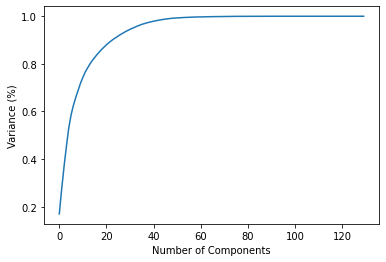

array([ 16.98316578,  27.34516601,  36.70636765,  45.24164289,
        52.98779207,  58.58736929,  62.65046152,  65.98630289,
        69.00818095,  71.88462111,  74.30738492,  76.60388819,
        78.32273091,  79.9721231 ,  81.42187884,  82.70002996,
        83.92393946,  85.05094905,  86.12073991,  87.09685162,
        88.03650244,  88.86005707,  89.66252715,  90.40823802,
        91.07053522,  91.72757079,  92.35530657,  92.93604888,
        93.50975167,  94.03841633,  94.51725671,  94.97270045,
        95.41110121,  95.83705963,  96.23255204,  96.59667955,
        96.90883224,  97.1921651 ,  97.4572665 ,  97.69354652,
        97.91995976,  98.11848802,  98.31219318,  98.49686805,
        98.66770333,  98.80566854,  98.93588768,  99.05649548,
        99.15845596,  99.23906433,  99.31004431,  99.37373898,
        99.43236925,  99.48218315,  99.5287526 ,  99.57210852,
        99.61519771,  99.64945729,  99.67893466,  99.70614872,
        99.7297222 ,  99.75282075,  99.77429121,  99.79

In [269]:
# PCA 
pca = PCA().fit(train_f1)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') # for each component
plt.show()
np.cumsum(pca.explained_variance_ratio_) * 100
# reach 85% variance explained with 18 principle components

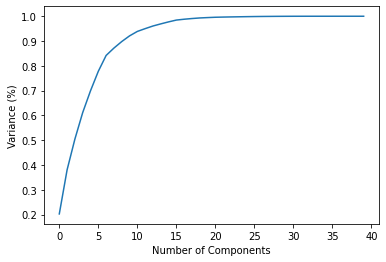

array([ 20.24212885,  38.02617731,  50.44856687,  61.13988758,
        69.92592078,  77.79039734,  84.17845677,  87.15725677,
        89.78415452,  92.07319006,  93.87212393,  94.99799805,
        96.05968155,  96.91522444,  97.72541737,  98.45547762,
        98.79644648,  99.07616783,  99.31039486,  99.45970401,
        99.59219281,  99.66594409,  99.72615157,  99.78073907,
        99.83190133,  99.87760143,  99.91403726,  99.93814699,
        99.9604413 ,  99.97672229,  99.98891876,  99.99416623,
        99.99669772,  99.99818394,  99.99899062,  99.99957681,
       100.        , 100.        , 100.        , 100.        ])

In [270]:
#PCA with 40 best components
pca_1 = PCA().fit(train_f1[feats_1])
plt.figure()
plt.plot(np.cumsum(pca_1.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') # for each component
plt.show()
np.cumsum(pca_1.explained_variance_ratio_) * 100
# can use 7 principle compents now

Keeping score: Will test 4 models with Ford_1 data variations,
- Model_1_0 = All varaibles,
- Model_1_1 = PCA All varaibles
- Model_1_2 = 40 best k score
- Model_1_3 = PCA of 40 Best K Score

### Model_1_0

In [271]:
# Model_1_0 final data prep

# converting to window format, in this case 5 periods
train_X_1_0, train_f1t_tc = df_to_X_y2(train_f1,train_f1t)
val_X_1_0, val_f1t_tc= df_to_X_y2(val_f1, val_f1t)
test_X_1_0, test_f1t_tc = df_to_X_y2(test_f1,test_f1t) 

In [272]:
n_steps = train_X_1_0.shape[1]
n_features = train_X_1_0.shape[2]

model_1_0_1 = Sequential()
model_1_0_1.add(Conv1D(filters=5, kernel_size=2, activation='relu', input_shape=(n_steps,n_features))) 
model_1_0_1.add(MaxPooling1D(pool_size=2)) 
model_1_0_1.add(Flatten())
model_1_0_1.add(Dense(50, activation='relu')) 
model_1_0_1.add(Dense(1, activation='sigmoid'))

model_1_0_1.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_1_0_1.fit(train_X_1_0, train_f1t_tc,epochs=100,  validation_data=(val_X_1_0, val_f1t_tc))

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


17/17 [==============================] - 1s 14ms/step - loss: 0.6948 - accuracy: 0.5113 - val_loss: 0.6949 - val_accuracy: 0.5101
Epoch 2/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6921 - accuracy: 0.5376 - val_loss: 0.6956 - val_accuracy: 0.5101
Epoch 3/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6914 - accuracy: 0.5338 - val_loss: 0.6940 - val_accuracy: 0.5235
Epoch 4/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6887 - accuracy: 0.5376 - val_loss: 0.6976 - val_accuracy: 0.4966
Epoch 5/100
17/17 [==============================] - 0s 5ms/step - loss: 0.6867 - accuracy: 0.5583 - val_loss: 0.6972 - val_accuracy: 0.4832
Epoch 6/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6850 - accuracy: 0.5620 - val_loss: 0.6983 - val_accuracy: 0.5101
Epoch 7/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6828 - accuracy: 0.5639 - val_loss: 0.7003 - val_accuracy: 0.4966
Epoch 8/100
17/17 [=====

In [273]:
model_1_0_2 = Sequential()
model_1_0_2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features))) 
model_1_0_2.add(MaxPooling1D(pool_size=2)) 
model_1_0_2.add(Flatten())
model_1_0_2.add(Dense(50, activation='relu')) 
model_1_0_2.add(Dense(1, activation='sigmoid'))

model_1_0_2.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_1_0_2.fit(train_X_1_0,train_f1t_tc,epochs=100,  validation_data=(val_X_1_0, val_f1t_tc))

Epoch 1/100
17/17 [==============================] - 1s 13ms/step - loss: 0.7285 - accuracy: 0.4812 - val_loss: 0.6882 - val_accuracy: 0.5638
Epoch 2/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6945 - accuracy: 0.5282 - val_loss: 0.6959 - val_accuracy: 0.4966
Epoch 3/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6829 - accuracy: 0.5620 - val_loss: 0.6924 - val_accuracy: 0.4899
Epoch 4/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6737 - accuracy: 0.6165 - val_loss: 0.6933 - val_accuracy: 0.5168
Epoch 5/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6751 - accuracy: 0.5846 - val_loss: 0.7414 - val_accuracy: 0.4966
Epoch 6/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6652 - accuracy: 0.5771 - val_loss: 0.6950 - val_accuracy: 0.5168
Epoch 7/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6447 - accuracy: 0.6936 - val_loss: 0.7239 - val_accuracy: 0.4631
Epoch 8/100


In [274]:
model_1_0_3 = Sequential()
model_1_0_3.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_1_0_3.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_1_0_3.add(MaxPooling1D(pool_size=2)) 
model_1_0_3.add(Flatten())
model_1_0_3.add(Dense(50, activation='relu')) 
model_1_0_3.add(Dense(1, activation='sigmoid')) 

model_1_0_3.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_1_0_3.fit(train_X_1_0,train_f1t_tc,epochs=100,  validation_data=(val_X_1_0, val_f1t_tc))

Epoch 1/100
17/17 [==============================] - 1s 16ms/step - loss: 0.6965 - accuracy: 0.5132 - val_loss: 0.7026 - val_accuracy: 0.5168
Epoch 2/100
17/17 [==============================] - 0s 9ms/step - loss: 0.6938 - accuracy: 0.5038 - val_loss: 0.6958 - val_accuracy: 0.4765
Epoch 3/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6830 - accuracy: 0.5789 - val_loss: 0.7035 - val_accuracy: 0.4765
Epoch 4/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6778 - accuracy: 0.5752 - val_loss: 0.7042 - val_accuracy: 0.4295
Epoch 5/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6655 - accuracy: 0.6034 - val_loss: 0.7187 - val_accuracy: 0.4966
Epoch 6/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6803 - accuracy: 0.5526 - val_loss: 0.7076 - val_accuracy: 0.4765
Epoch 7/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6603 - accuracy: 0.6316 - val_loss: 0.7072 - val_accuracy: 0.4631
Epoch 8/100


In [275]:
model_1_0_4 = Sequential()
model_1_0_4.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_1_0_4.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_1_0_4.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_1_0_4.add(MaxPooling1D(pool_size=2)) 
model_1_0_4.add(Conv1D(filters=32, kernel_size=1, activation='relu')) 
model_1_0_4.add(Flatten())
model_1_0_4.add(Dense(50, activation='relu')) 
model_1_0_4.add(Dense(1, activation='sigmoid')) 
model_1_0_4.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_1_0_4.fit(train_X_1_0,train_f1t_tc,epochs=100,  validation_data=(val_X_1_0, val_f1t_tc))

Epoch 1/100
17/17 [==============================] - 1s 16ms/step - loss: 0.6979 - accuracy: 0.4774 - val_loss: 0.6938 - val_accuracy: 0.4899
Epoch 2/100
17/17 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.5282 - val_loss: 0.6952 - val_accuracy: 0.5034
Epoch 3/100
17/17 [==============================] - 0s 5ms/step - loss: 0.6905 - accuracy: 0.5282 - val_loss: 0.6948 - val_accuracy: 0.5034
Epoch 4/100
17/17 [==============================] - 0s 5ms/step - loss: 0.6878 - accuracy: 0.5620 - val_loss: 0.6988 - val_accuracy: 0.4966
Epoch 5/100
17/17 [==============================] - 0s 7ms/step - loss: 0.6824 - accuracy: 0.5789 - val_loss: 0.6975 - val_accuracy: 0.5302
Epoch 6/100
17/17 [==============================] - 0s 5ms/step - loss: 0.6778 - accuracy: 0.5883 - val_loss: 0.7003 - val_accuracy: 0.4966
Epoch 7/100
17/17 [==============================] - 0s 5ms/step - loss: 0.6604 - accuracy: 0.6504 - val_loss: 0.7439 - val_accuracy: 0.4832
Epoch 8/100


## Model_1_1

In [276]:
# Model_0_1 final data prep 

# PCA with 23 components to explain 85% of variance
sklearn_pca = PCA(n_components=18)
train_X_1_1 = pd.DataFrame(sklearn_pca.fit_transform(train_f1))
val_X_1_1 = pd.DataFrame(sklearn_pca.transform(val_f1))
test_X_1_1 = pd.DataFrame(sklearn_pca.transform(test_f1))


# converting to window format, in this case 5 periods
train_X_1_1, _ = df_to_X_np(train_X_1_1)
val_X_1_1, _ = df_to_X_np(val_X_1_1)
test_X_1_1, _ = df_to_X_np(test_X_1_1)


In [277]:

n_steps = train_X_1_1.shape[1]
n_features = train_X_1_1.shape[2]

model_1_1_1 = Sequential()
model_1_1_1.add(Conv1D(filters=5, kernel_size=2, activation='relu', input_shape=(n_steps,n_features))) 
model_1_1_1.add(MaxPooling1D(pool_size=2)) 
model_1_1_1.add(Flatten())
model_1_1_1.add(Dense(50, activation='relu')) 
model_1_1_1.add(Dense(1, activation='sigmoid'))

model_1_1_1.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_1_1_1.fit(train_X_1_1, train_f1t_tc,epochs=100,  validation_data=(val_X_1_1, val_f1t_tc))

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


17/17 [==============================] - 1s 12ms/step - loss: 0.7012 - accuracy: 0.5207 - val_loss: 0.6944 - val_accuracy: 0.5369
Epoch 2/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6940 - accuracy: 0.5207 - val_loss: 0.6938 - val_accuracy: 0.5302
Epoch 3/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6905 - accuracy: 0.5282 - val_loss: 0.6942 - val_accuracy: 0.5503
Epoch 4/100
17/17 [==============================] - 0s 5ms/step - loss: 0.6865 - accuracy: 0.5320 - val_loss: 0.6946 - val_accuracy: 0.5369
Epoch 5/100
17/17 [==============================] - 0s 5ms/step - loss: 0.6844 - accuracy: 0.5376 - val_loss: 0.6953 - val_accuracy: 0.5302
Epoch 6/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6817 - accuracy: 0.5451 - val_loss: 0.6951 - val_accuracy: 0.5369
Epoch 7/100
17/17 [==============================] - 0s 5ms/step - loss: 0.6799 - accuracy: 0.5489 - val_loss: 0.6950 - val_accuracy: 0.5436
Epoch 8/100
17/17 [=====

In [278]:
model_1_1_2 = Sequential()
model_1_1_2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features))) 
model_1_1_2.add(MaxPooling1D(pool_size=2)) 
model_1_1_2.add(Flatten())
model_1_1_2.add(Dense(50, activation='relu')) 
model_1_1_2.add(Dense(1, activation='sigmoid'))

model_1_1_2.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_1_1_2.fit(train_X_1_1,train_f1t_tc,epochs=100,  validation_data=(val_X_1_1, val_f1t_tc))

Epoch 1/100
17/17 [==============================] - 1s 12ms/step - loss: 0.7115 - accuracy: 0.5113 - val_loss: 0.7056 - val_accuracy: 0.4832
Epoch 2/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.5583 - val_loss: 0.6960 - val_accuracy: 0.5503
Epoch 3/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6641 - accuracy: 0.6090 - val_loss: 0.6975 - val_accuracy: 0.5436
Epoch 4/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6531 - accuracy: 0.6165 - val_loss: 0.7014 - val_accuracy: 0.5369
Epoch 5/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6373 - accuracy: 0.6767 - val_loss: 0.7053 - val_accuracy: 0.5101
Epoch 6/100
17/17 [==============================] - 0s 3ms/step - loss: 0.6259 - accuracy: 0.6767 - val_loss: 0.7070 - val_accuracy: 0.4966
Epoch 7/100
17/17 [==============================] - 0s 3ms/step - loss: 0.6075 - accuracy: 0.7274 - val_loss: 0.7100 - val_accuracy: 0.4966
Epoch 8/100


In [279]:
model_1_1_3 = Sequential()
model_1_1_3.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_1_1_3.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_1_1_3.add(MaxPooling1D(pool_size=2)) 
model_1_1_3.add(Flatten())
model_1_1_3.add(Dense(50, activation='relu')) 
model_1_1_3.add(Dense(1, activation='sigmoid')) 

model_1_1_3.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_1_1_3.fit(train_X_1_1,train_f1t_tc,epochs=100,  validation_data=(val_X_1_1, val_f1t_tc))

Epoch 1/100
17/17 [==============================] - 1s 13ms/step - loss: 0.7130 - accuracy: 0.5169 - val_loss: 0.7057 - val_accuracy: 0.3960
Epoch 2/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6826 - accuracy: 0.5658 - val_loss: 0.7037 - val_accuracy: 0.4497
Epoch 3/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6676 - accuracy: 0.6053 - val_loss: 0.7059 - val_accuracy: 0.4765
Epoch 4/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6559 - accuracy: 0.6673 - val_loss: 0.7078 - val_accuracy: 0.4765
Epoch 5/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6394 - accuracy: 0.6673 - val_loss: 0.7134 - val_accuracy: 0.4631
Epoch 6/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6200 - accuracy: 0.7331 - val_loss: 0.7223 - val_accuracy: 0.4765
Epoch 7/100
17/17 [==============================] - 0s 4ms/step - loss: 0.5972 - accuracy: 0.7688 - val_loss: 0.7324 - val_accuracy: 0.4295
Epoch 8/100


In [280]:
model_1_1_4 = Sequential()
model_1_1_4.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_1_1_4.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_1_1_4.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_1_1_4.add(MaxPooling1D(pool_size=2)) 
model_1_1_4.add(Conv1D(filters=32, kernel_size=1, activation='relu')) 
model_1_1_4.add(Flatten())
model_1_1_4.add(Dense(50, activation='relu')) 
model_1_1_4.add(Dense(1, activation='sigmoid')) 
model_1_1_4.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_1_1_4.fit(train_X_1_1,train_f1t_tc,epochs=100,  validation_data=(val_X_1_1, val_f1t_tc))

Epoch 1/100
17/17 [==============================] - 1s 19ms/step - loss: 0.6959 - accuracy: 0.5075 - val_loss: 0.6923 - val_accuracy: 0.5235
Epoch 2/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6859 - accuracy: 0.5451 - val_loss: 0.6952 - val_accuracy: 0.5168
Epoch 3/100
17/17 [==============================] - 0s 5ms/step - loss: 0.6762 - accuracy: 0.5959 - val_loss: 0.6953 - val_accuracy: 0.4631
Epoch 4/100
17/17 [==============================] - 0s 5ms/step - loss: 0.6626 - accuracy: 0.6917 - val_loss: 0.6977 - val_accuracy: 0.5235
Epoch 5/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6398 - accuracy: 0.7331 - val_loss: 0.7073 - val_accuracy: 0.4161
Epoch 6/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6028 - accuracy: 0.7425 - val_loss: 0.7325 - val_accuracy: 0.4832
Epoch 7/100
17/17 [==============================] - 0s 9ms/step - loss: 0.5520 - accuracy: 0.7857 - val_loss: 0.7568 - val_accuracy: 0.4832
Epoch 8/100


## Model_1_2

In [281]:
# converting to window format, in this case 5 periods
train_X_1_2, train_f1t_tc = df_to_X_y2(train_f1[feats_1],train_f1t)
val_X_1_2, val_f1t_tc= df_to_X_y2(val_f1[feats_1], val_f1t)
test_X_1_2, test_f1t_tc = df_to_X_y2(test_f1[feats_1],test_f1t) 

In [282]:
n_steps = train_X_1_2.shape[1]
n_features = train_X_1_2.shape[2]

model_1_2_1 = Sequential()
model_1_2_1.add(Conv1D(filters=5, kernel_size=2, activation='relu', input_shape=(n_steps,n_features))) 
model_1_2_1.add(MaxPooling1D(pool_size=2)) 
model_1_2_1.add(Flatten())
model_1_2_1.add(Dense(50, activation='relu')) 
model_1_2_1.add(Dense(1, activation='sigmoid'))

model_1_2_1.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_1_2_1.fit(train_X_1_2, train_f1t_tc,epochs=100,  validation_data=(val_X_1_2, val_f1t_tc))

Epoch 1/100
17/17 [==============================] - 1s 12ms/step - loss: 0.6956 - accuracy: 0.5094 - val_loss: 0.6882 - val_accuracy: 0.5369
Epoch 2/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.5038 - val_loss: 0.6875 - val_accuracy: 0.5436
Epoch 3/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.5244 - val_loss: 0.6906 - val_accuracy: 0.5034
Epoch 4/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6897 - accuracy: 0.5376 - val_loss: 0.6902 - val_accuracy: 0.5168
Epoch 5/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.5320 - val_loss: 0.6880 - val_accuracy: 0.5369
Epoch 6/100
17/17 [==============================] - 0s 5ms/step - loss: 0.6879 - accuracy: 0.5357 - val_loss: 0.6906 - val_accuracy: 0.5168
Epoch 7/100
17/17 [==============================] - 0s 5ms/step - loss: 0.6879 - accuracy: 0.5414 - val_loss: 0.6889 - val_accuracy: 0.4966
Epoch 8/100


In [283]:
model_1_2_2 = Sequential()
model_1_2_2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features))) 
model_1_2_2.add(MaxPooling1D(pool_size=2)) 
model_1_2_2.add(Flatten())
model_1_2_2.add(Dense(50, activation='relu')) 
model_1_2_2.add(Dense(1, activation='sigmoid'))

model_1_2_2.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_1_2_2.fit(train_X_1_2,train_f1t_tc,epochs=100,  validation_data=(val_X_1_2, val_f1t_tc))

Epoch 1/100
17/17 [==============================] - 1s 13ms/step - loss: 0.7096 - accuracy: 0.5169 - val_loss: 0.7176 - val_accuracy: 0.4966
Epoch 2/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6863 - accuracy: 0.5526 - val_loss: 0.7066 - val_accuracy: 0.5101
Epoch 3/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6868 - accuracy: 0.5432 - val_loss: 0.6985 - val_accuracy: 0.5101
Epoch 4/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6819 - accuracy: 0.5620 - val_loss: 0.7063 - val_accuracy: 0.4899
Epoch 5/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6751 - accuracy: 0.5583 - val_loss: 0.6997 - val_accuracy: 0.5034
Epoch 6/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6613 - accuracy: 0.6560 - val_loss: 0.6986 - val_accuracy: 0.4832
Epoch 7/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6533 - accuracy: 0.6805 - val_loss: 0.7057 - val_accuracy: 0.4899
Epoch 8/100


In [284]:
model_1_2_3 = Sequential()
model_1_2_3.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_1_2_3.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_1_2_3.add(MaxPooling1D(pool_size=2)) 
model_1_2_3.add(Flatten())
model_1_2_3.add(Dense(50, activation='relu')) 
model_1_2_3.add(Dense(1, activation='sigmoid')) 

model_1_2_3.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_1_2_3.fit(train_X_1_2,train_f1t_tc,epochs=100,  validation_data=(val_X_1_2, val_f1t_tc))

Epoch 1/100
17/17 [==============================] - 1s 13ms/step - loss: 0.6952 - accuracy: 0.5301 - val_loss: 0.6945 - val_accuracy: 0.4966
Epoch 2/100
17/17 [==============================] - 0s 5ms/step - loss: 0.6891 - accuracy: 0.5338 - val_loss: 0.6955 - val_accuracy: 0.4832
Epoch 3/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6844 - accuracy: 0.5883 - val_loss: 0.6931 - val_accuracy: 0.5101
Epoch 4/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6816 - accuracy: 0.5620 - val_loss: 0.6934 - val_accuracy: 0.5101
Epoch 5/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6779 - accuracy: 0.5752 - val_loss: 0.6949 - val_accuracy: 0.4966
Epoch 6/100
17/17 [==============================] - 0s 5ms/step - loss: 0.6637 - accuracy: 0.6109 - val_loss: 0.7075 - val_accuracy: 0.4564
Epoch 7/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6552 - accuracy: 0.6541 - val_loss: 0.7014 - val_accuracy: 0.5101
Epoch 8/100


In [285]:
model_1_2_4 = Sequential()
model_1_2_4.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_1_2_4.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_1_2_4.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_1_2_4.add(MaxPooling1D(pool_size=2)) 
model_1_2_4.add(Conv1D(filters=32, kernel_size=1, activation='relu')) 
model_1_2_4.add(Flatten())
model_1_2_4.add(Dense(50, activation='relu')) 
model_1_2_4.add(Dense(1, activation='sigmoid')) 
model_1_2_4.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_1_2_4.fit(train_X_1_2,train_f1t_tc,epochs=100,  validation_data=(val_X_1_2, val_f1t_tc))

Epoch 1/100
17/17 [==============================] - 1s 16ms/step - loss: 0.6966 - accuracy: 0.5282 - val_loss: 0.6925 - val_accuracy: 0.5369
Epoch 2/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.5470 - val_loss: 0.6928 - val_accuracy: 0.5369
Epoch 3/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6884 - accuracy: 0.5357 - val_loss: 0.6926 - val_accuracy: 0.5369
Epoch 4/100
17/17 [==============================] - 0s 5ms/step - loss: 0.6870 - accuracy: 0.5338 - val_loss: 0.6934 - val_accuracy: 0.4832
Epoch 5/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6838 - accuracy: 0.5639 - val_loss: 0.6919 - val_accuracy: 0.5369
Epoch 6/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6738 - accuracy: 0.5865 - val_loss: 0.6942 - val_accuracy: 0.4765
Epoch 7/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6670 - accuracy: 0.6278 - val_loss: 0.6988 - val_accuracy: 0.5235
Epoch 8/100


## Model_1_3

In [286]:
# PCA with 8 components to explain 85% of variance
sklearn_pca = PCA(n_components=7)
train_X_1_3 = pd.DataFrame(sklearn_pca.fit_transform(train_f1[feats_1]))
val_X_1_3 = pd.DataFrame(sklearn_pca.transform(val_f1[feats_1]))
test_X_1_3 = pd.DataFrame(sklearn_pca.transform(test_f1[feats_1]))
train_X_1_3, _ = df_to_X_np(train_X_1_3)
val_X_1_3, _ = df_to_X_np(val_X_1_3)
test_X_1_3, _ = df_to_X_np(test_X_1_3)

In [287]:
n_steps = train_X_1_3.shape[1]
n_features = train_X_1_3.shape[2]

model_1_3_1 = Sequential()
model_1_3_1.add(Conv1D(filters=5, kernel_size=2, activation='relu', input_shape=(n_steps,n_features))) 
model_1_3_1.add(MaxPooling1D(pool_size=2)) 
model_1_3_1.add(Flatten())
model_1_3_1.add(Dense(50, activation='relu')) 
model_1_3_1.add(Dense(1, activation='sigmoid'))

model_1_3_1.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_1_3_1.fit(train_X_1_3, train_f1t_tc,epochs=100,  validation_data=(val_X_1_3, val_f1t_tc))

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


17/17 [==============================] - 1s 12ms/step - loss: 0.6988 - accuracy: 0.5338 - val_loss: 0.7090 - val_accuracy: 0.4966
Epoch 2/100
17/17 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.5395 - val_loss: 0.7026 - val_accuracy: 0.5168
Epoch 3/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6896 - accuracy: 0.5564 - val_loss: 0.7027 - val_accuracy: 0.5302
Epoch 4/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6874 - accuracy: 0.5639 - val_loss: 0.7003 - val_accuracy: 0.5235
Epoch 5/100
17/17 [==============================] - 0s 3ms/step - loss: 0.6853 - accuracy: 0.5658 - val_loss: 0.6997 - val_accuracy: 0.5101
Epoch 6/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6843 - accuracy: 0.5677 - val_loss: 0.7013 - val_accuracy: 0.5034
Epoch 7/100
17/17 [==============================] - 0s 5ms/step - loss: 0.6823 - accuracy: 0.5752 - val_loss: 0.6966 - val_accuracy: 0.4966
Epoch 8/100
17/17 [=====

In [288]:
model_1_3_2 = Sequential()
model_1_3_2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features))) 
model_1_3_2.add(MaxPooling1D(pool_size=2)) 
model_1_3_2.add(Flatten())
model_1_3_2.add(Dense(50, activation='relu')) 
model_1_3_2.add(Dense(1, activation='sigmoid'))

model_1_3_2.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_1_3_2.fit(train_X_1_3,train_f1t_tc,epochs=100,  validation_data=(val_X_1_3, val_f1t_tc))

Epoch 1/100
17/17 [==============================] - 1s 13ms/step - loss: 0.6931 - accuracy: 0.5150 - val_loss: 0.6992 - val_accuracy: 0.5168
Epoch 2/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6783 - accuracy: 0.5526 - val_loss: 0.7006 - val_accuracy: 0.5101
Epoch 3/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6702 - accuracy: 0.5902 - val_loss: 0.7006 - val_accuracy: 0.5235
Epoch 4/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6635 - accuracy: 0.6222 - val_loss: 0.7023 - val_accuracy: 0.5034
Epoch 5/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6577 - accuracy: 0.6541 - val_loss: 0.7037 - val_accuracy: 0.5034
Epoch 6/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6505 - accuracy: 0.6466 - val_loss: 0.7059 - val_accuracy: 0.4966
Epoch 7/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6416 - accuracy: 0.6898 - val_loss: 0.7092 - val_accuracy: 0.4765
Epoch 8/100


In [289]:
model_1_3_3 = Sequential()
model_1_3_3.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_1_3_3.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_1_3_3.add(MaxPooling1D(pool_size=2)) 
model_1_3_3.add(Flatten())
model_1_3_3.add(Dense(50, activation='relu')) 
model_1_3_3.add(Dense(1, activation='sigmoid')) 

model_1_3_3.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_1_3_3.fit(train_X_1_3,train_f1t_tc,epochs=100,  validation_data=(val_X_1_3, val_f1t_tc))

Epoch 1/100
17/17 [==============================] - 1s 13ms/step - loss: 0.6960 - accuracy: 0.4925 - val_loss: 0.6994 - val_accuracy: 0.4698
Epoch 2/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6864 - accuracy: 0.5451 - val_loss: 0.7026 - val_accuracy: 0.4899
Epoch 3/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6803 - accuracy: 0.5771 - val_loss: 0.7019 - val_accuracy: 0.4430
Epoch 4/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6738 - accuracy: 0.5714 - val_loss: 0.7070 - val_accuracy: 0.4765
Epoch 5/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6675 - accuracy: 0.5921 - val_loss: 0.7066 - val_accuracy: 0.4564
Epoch 6/100
17/17 [==============================] - 0s 5ms/step - loss: 0.6574 - accuracy: 0.6429 - val_loss: 0.7135 - val_accuracy: 0.4765
Epoch 7/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6458 - accuracy: 0.6673 - val_loss: 0.7159 - val_accuracy: 0.4698
Epoch 8/100


In [290]:
model_1_3_4 = Sequential()
model_1_3_4.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_1_3_4.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_1_3_4.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_1_3_4.add(MaxPooling1D(pool_size=2)) 
model_1_3_4.add(Conv1D(filters=32, kernel_size=1, activation='relu')) 
model_1_3_4.add(Flatten())
model_1_3_4.add(Dense(50, activation='relu')) 
model_1_3_4.add(Dense(1, activation='sigmoid')) 
model_1_3_4.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_1_3_4.fit(train_X_1_3,train_f1t_tc,epochs=100,  validation_data=(val_X_1_3, val_f1t_tc))

Epoch 1/100
17/17 [==============================] - 1s 16ms/step - loss: 0.6928 - accuracy: 0.5338 - val_loss: 0.6943 - val_accuracy: 0.5034
Epoch 2/100
17/17 [==============================] - 0s 5ms/step - loss: 0.6894 - accuracy: 0.5301 - val_loss: 0.6935 - val_accuracy: 0.5034
Epoch 3/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6865 - accuracy: 0.5432 - val_loss: 0.6947 - val_accuracy: 0.5034
Epoch 4/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6811 - accuracy: 0.5376 - val_loss: 0.6937 - val_accuracy: 0.5168
Epoch 5/100
17/17 [==============================] - 0s 6ms/step - loss: 0.6737 - accuracy: 0.5564 - val_loss: 0.6933 - val_accuracy: 0.4899
Epoch 6/100
17/17 [==============================] - 0s 5ms/step - loss: 0.6624 - accuracy: 0.6184 - val_loss: 0.6956 - val_accuracy: 0.4966
Epoch 7/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6444 - accuracy: 0.6805 - val_loss: 0.7027 - val_accuracy: 0.4362
Epoch 8/100
